In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import soundfile as sf
from pathlib import Path
import re
import json
import wave
import IPython.display as ipd

## Annotation DB

### define paths for annotations and audio files

In [9]:
annotation_csvfile_path = Path('bg_segments_table_from_EDA_notebook.csv')
recording_path = Path('/data/matlab_code/deep_voice/recordings_2018_filtered')

### load csv file to pandas df

In [10]:
tags = pd.read_csv(annotation_csvfile_path)

### inspect tags over x seconds

In [11]:
min_tag_len = 1
tags_to_inspect = tags[tags['BG Length'] > min_tag_len]

In [12]:
print('Number of tags to ispect:', tags_to_inspect.shape[0])

Number of tags to ispect: 631


## load audio and spectrogram

### define functions

In [13]:
def play_audio_plot_stft(df_series, audio_path):
    def get_sr(wav_path):
        with wave.open(str(wav_path), "rb") as wave_file:
            return wave_file.getframerate()
    
    def play_audio(audio_data, sr):
        ipd.display(ipd.Audio(audio_data, rate=sr))
    
    def plot_stft(audio_data, sr):
        plt.figure()
        D = librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max)
        librosa.display.specshow(D, y_axis='log', sr=sr, fmax=10000)
        plt.colorbar(format='%+2.0f dB')
    
    audio_file_path = audio_path / (df_series['FileName'] + '.wav')
    start_time = df_series['Begin Time (s)']
    end_time = df_series['End Time (s)']
    sr = get_sr(audio_file_path)
    audio_data, sr = sf.read(audio_file_path, start=int(start_time*sr), stop=int(end_time*sr))
    
    play_audio(audio_data, sr)
    plot_stft(audio_data, sr)

    
class Tagger():
    '''
    basic class for tagging
    use add_tag to add tag, idx the idx sent to iloc in dataframe, 1 for call and 0 for bg noise
    '''
    def __init__(self):
        self.counter = 0
        self.tags = {}
    
    def add_tag(self, idx, tag):
        self.tags[(idx)] = tag
        self.counter += 1
    
    def save_tags(self):
        with open('tagging.json', 'w') as fp:
            json.dump(self.tags, fp)
    
    def calc_ratio(self):
        positive_tags = sum([v for k,v in self.tags.items()])
        ratio = positive_tags / self.counter
        print(f'found {ratio} ratio of positive calls')

### extract call from dataframe and add to the tagger

#### init tagger

In [14]:
tagger = Tagger()

#### present and play tag, the example is for tag_index=10

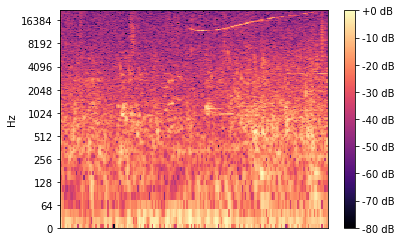

In [19]:
idx= 10
sample = tags_to_inspect.iloc[idx]
play_audio_plot_stft(sample, recording_path)

#### tag call. if the clip is bg, sound_type=0, for call use sound_type=1

In [15]:
tagger.add_tag(idx, 1)

#### When you finished the tagging, save the tagger as a json file

In [16]:
tagger.save_tags()